In [14]:
#numeric: pandas and numpy
import numpy as np
import pandas as pd
# graphics
%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 

from sklearn import linear_model, svm
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import cross_validate, GridSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

from mlxtend.evaluate import mcnemar

In [2]:
from sklearn.datasets import make_blobs, make_circles, make_moons, make_circles

X_blobs, y_blobs = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=None)

X_moon,y_moon= make_moons(n_samples=1000, shuffle=True, noise=None, random_state=None)

X_cir, y_cir= make_circles(n_samples=1000, shuffle=True, noise=None, random_state=None, factor=0.4)

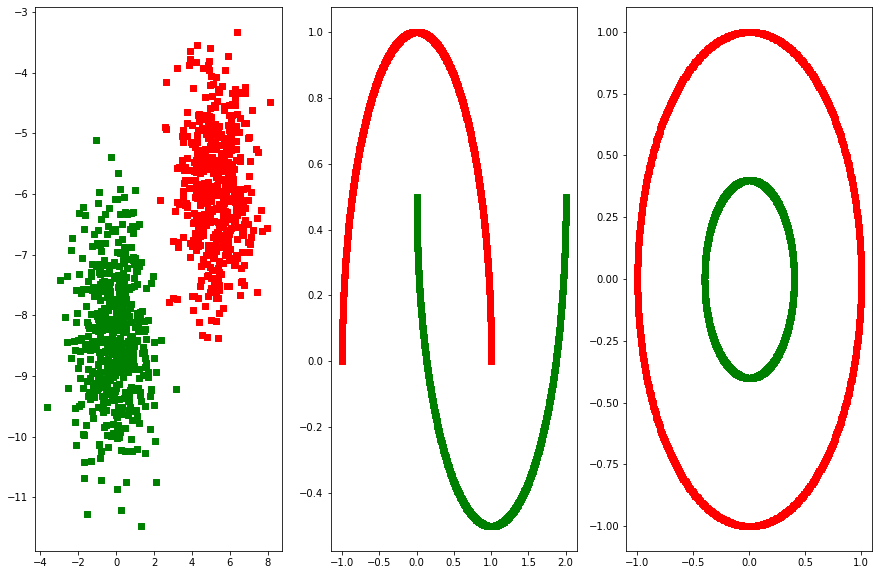

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))

ax1.scatter(X_blobs[y_blobs==0,0],X_blobs[y_blobs==0,1],marker='s',color='r',label='0' )
ax1.scatter(X_blobs[y_blobs==1,0],X_blobs[y_blobs==1,1],marker='s',color='g',label='0' )
#ax1.set_aspect('equal')
ax2.scatter(X_moon[y_moon==0,0],X_moon[y_moon==0,1],marker='s',color='r',label='0' )
ax2.scatter(X_moon[y_moon==1,0],X_moon[y_moon==1,1],marker='s',color='g',label='0' )

ax3.scatter(X_cir[y_cir==0,0],X_cir[y_cir==0,1],marker='s',color='r',label='0' )
ax3.scatter(X_cir[y_cir==1,0],X_cir[y_cir==1,1],marker='s',color='g',label='0' )

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X_blobs,y_blobs, test_size=0.2, random_state=44, stratify=y_blobs)

In [5]:
print("Training set feature matrix shape: " + str(x_train.shape))
print("Training set classification matrix shape: " + str(y_train.shape))
print("Testing set feature matrix shape: " + str(x_test.shape))
print("Testing set classification matrix shape: " + str(y_test.shape))
print("------------------------------------------------")

Training set feature matrix shape: (800, 2)
Training set classification matrix shape: (800,)
Testing set feature matrix shape: (200, 2)
Testing set classification matrix shape: (200,)
------------------------------------------------


In [6]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 400, 1: 400}


## SVM (Linear) vs SVM (RBF)

In [7]:
def compare_matrices(correct_values, model1_values, model2_values):
    model1_correct = np.array(correct_values == model1_values)
    model2_correct = np.array(correct_values == model2_values)
    res = np.zeros((2,2))
    res[0,0] = np.sum(np.logical_and(model1_correct, model2_correct))
    res[0,1] = np.sum(np.logical_and(model1_correct, np.logical_not(model2_correct)))
    res[1,0] = np.sum(np.logical_and(np.logical_not(model1_correct), model2_correct))
    res[1,1] = np.sum(np.logical_and(np.logical_not(model1_correct), np.logical_not(model2_correct)))
    
    return res

### Blobs

In [8]:
svmRBF = svm.SVC(kernel='rbf')
svmLinear = svm.SVC(kernel='linear')

In [9]:


k_fold = StratifiedKFold(n_splits=3)
X = X_moon
y = y_moon

dict = {"Blobs": (X_blobs, y_blobs), "Moon": (X_moon, y_moon), "Circle": (X_cir, y_cir)}

sections = []
for k,v in dict.items():
    sub_section = []
    print("----------------", k, "----------------")
    for train_indices, test_indices in k_fold.split(v[0],v[1]):
        
        scaler = StandardScaler() 
        X_train=X[train_indices]

        Xs=scaler.fit_transform(X_train)

        Xtest=scaler.transform(X[test_indices])

        svmRBF.fit(Xs,y[train_indices])
        svmLinear.fit(Xs, y[train_indices])

        y_pred_rbf=svmRBF.predict(Xtest)
        y_pred_lin=svmLinear.predict(Xtest)
        print("Conf Matrix RBF\n", confusion_matrix(y[test_indices],y_pred_rbf))
        print("Conf Matrix Linear\n", confusion_matrix(y[test_indices],y_pred_lin))
        sub_section.append(compare_matrices(y[test_indices], y_pred_rbf, y_pred_lin))
    sections.append(sub_section)
    

---------------- Blobs ----------------
Conf Matrix RBF
 [[172   0]
 [  0 162]]
Conf Matrix Linear
 [[160  12]
 [ 23 139]]
Conf Matrix RBF
 [[167   0]
 [  0 166]]
Conf Matrix Linear
 [[142  25]
 [ 16 150]]
Conf Matrix RBF
 [[161   0]
 [  0 172]]
Conf Matrix Linear
 [[140  21]
 [ 18 154]]
---------------- Moon ----------------
Conf Matrix RBF
 [[167   0]
 [  0 167]]
Conf Matrix Linear
 [[156  11]
 [ 22 145]]
Conf Matrix RBF
 [[167   0]
 [  0 166]]
Conf Matrix Linear
 [[144  23]
 [ 18 148]]
Conf Matrix RBF
 [[166   0]
 [  0 167]]
Conf Matrix Linear
 [[141  25]
 [ 16 151]]
---------------- Circle ----------------
Conf Matrix RBF
 [[173   0]
 [  0 161]]
Conf Matrix Linear
 [[162  11]
 [ 22 139]]
Conf Matrix RBF
 [[165   0]
 [  0 168]]
Conf Matrix Linear
 [[140  25]
 [ 17 151]]
Conf Matrix RBF
 [[162   0]
 [  0 171]]
Conf Matrix Linear
 [[140  22]
 [ 18 153]]


In [12]:
for ds in range(len(sections)):
    for model in range(len(sections[ds])):
        contingency_table = sections[ds][model]
        print("(hand-made) chi-squared: ", ((np.abs(contingency_table[0,1] - contingency_table[1,0]) - 1)**2)/(contingency_table[0,1] + contingency_table[1,0]))
        chi2, p = mcnemar(ary=contingency_table, corrected=True)
        print('chi-squared:', chi2)
        print('p-value:', p) 

(hand-made) chi-squared:  33.02857142857143
chi-squared: 33.02857142857143
p-value: 9.081445518184979e-09
(hand-made) chi-squared:  39.02439024390244
chi-squared: 39.02439024390244
p-value: 4.1854369440036287e-10
(hand-made) chi-squared:  37.02564102564103
chi-squared: 37.02564102564103
p-value: 1.1658598093780509e-09
(hand-made) chi-squared:  31.03030303030303
chi-squared: 31.03030303030303
p-value: 2.5403120142884262e-08
(hand-made) chi-squared:  39.02439024390244
chi-squared: 39.02439024390244
p-value: 4.1854369440036287e-10
(hand-made) chi-squared:  39.02439024390244
chi-squared: 39.02439024390244
p-value: 4.1854369440036287e-10
(hand-made) chi-squared:  31.03030303030303
chi-squared: 31.03030303030303
p-value: 2.5403120142884262e-08
(hand-made) chi-squared:  40.023809523809526
chi-squared: 40.023809523809526
p-value: 2.508860953006117e-10
(hand-made) chi-squared:  38.025
chi-squared: 38.025
p-value: 6.984393061522137e-10


## Percepton vs Multilayer feedforward neural network

In [15]:
ppn=Perceptron(penalty=None, alpha=0.0001, fit_intercept=True, max_iter=20, tol=None, 
               eta0=0.1, n_jobs=1, random_state=0, class_weight=None, warm_start=False)


ppnML = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1)

In [16]:
sections = []
for k,v in dict.items():
    sub_section = []
    print("----------------", k, "----------------")
    for train_indices, test_indices in k_fold.split(v[0],v[1]):
        scaler = StandardScaler() 
        X_train=X[train_indices]

        Xs=scaler.fit_transform(X_train)

        Xtest=scaler.transform(X[test_indices])

        ppn.fit(Xs,y[train_indices])
        ppnML.fit(Xs, y[train_indices])

        y_pred_ppn=ppn.predict(Xtest)
        y_pred_ppnML=ppnML.predict(Xtest)

        print("Conf Matrix ppn\n", confusion_matrix(y[test_indices],y_pred_ppn))
        print("Conf Matrix ppnML\n", confusion_matrix(y[test_indices],y_pred_ppnML))
        sub_section.append(compare_matrices(y[test_indices], y_pred_ppn, y_pred_ppnML))
    sections.append(sub_section)
    

---------------- Blobs ----------------
Conf Matrix ppn
 [[149  23]
 [ 33 129]]
Conf Matrix ppnML
 [[172   0]
 [  0 162]]
Conf Matrix ppn
 [[144  23]
 [ 14 152]]
Conf Matrix ppnML
 [[167   0]
 [  0 166]]
Conf Matrix ppn
 [[116  45]
 [  5 167]]
Conf Matrix ppnML
 [[161   0]
 [  0 172]]
---------------- Moon ----------------
Conf Matrix ppn
 [[153  14]
 [ 26 141]]
Conf Matrix ppnML
 [[167   0]
 [  0 167]]
Conf Matrix ppn
 [[137  30]
 [ 25 141]]
Conf Matrix ppnML
 [[167   0]
 [  0 166]]
Conf Matrix ppn
 [[121  45]
 [  9 158]]
Conf Matrix ppnML
 [[166   0]
 [  0 167]]
---------------- Circle ----------------
Conf Matrix ppn
 [[171   2]
 [ 47 114]]
Conf Matrix ppnML
 [[173   0]
 [  0 161]]
Conf Matrix ppn
 [[138  27]
 [ 17 151]]
Conf Matrix ppnML
 [[165   0]
 [  0 168]]
Conf Matrix ppn
 [[118  44]
 [  7 164]]
Conf Matrix ppnML
 [[162   0]
 [  0 171]]


In [17]:
for ds in range(len(sections)):
    for model in range(len(sections[ds])):
        contingency_table = sections[ds][model]
        print("(hand-made) chi-squared: ", ((np.abs(contingency_table[0,1] - contingency_table[1,0]) - 1)**2)/(contingency_table[0,1] + contingency_table[1,0]))
        chi2, p = mcnemar(ary=contingency_table, corrected=True)
        print('chi-squared:', chi2)
        print('p-value:', p) 

(hand-made) chi-squared:  54.017857142857146
chi-squared: 54.017857142857146
p-value: 1.9867575986578073e-13
(hand-made) chi-squared:  35.027027027027025
chi-squared: 35.027027027027025
p-value: 3.2516061726496955e-09
(hand-made) chi-squared:  48.02
chi-squared: 48.02
p-value: 4.218936524005768e-12
(hand-made) chi-squared:  38.025
chi-squared: 38.025
p-value: 6.984393061522137e-10
(hand-made) chi-squared:  53.018181818181816
chi-squared: 53.018181818181816
p-value: 3.304751303805302e-13
(hand-made) chi-squared:  52.01851851851852
chi-squared: 52.01851851851852
p-value: 5.497966755051709e-13
(hand-made) chi-squared:  47.02040816326531
chi-squared: 47.02040816326531
p-value: 7.02513719345829e-12
(hand-made) chi-squared:  42.02272727272727
chi-squared: 42.02272727272727
p-value: 9.021872818347158e-11
(hand-made) chi-squared:  49.01960784313726
chi-squared: 49.01960784313726
p-value: 2.534165198030962e-12
